Epoch 0 | Adversarial Loss: 0.0744
Epoch 1 | Adversarial Loss: 0.0579
Epoch 2 | Adversarial Loss: 0.0516
Epoch 3 | Adversarial Loss: 0.0494
Epoch 4 | Adversarial Loss: 0.0465
Epoch 5 | Adversarial Loss: 0.0471
Epoch 6 | Adversarial Loss: 0.0447
Epoch 7 | Adversarial Loss: 0.0418
Epoch 8 | Adversarial Loss: 0.0424
Epoch 9 | Adversarial Loss: 0.0404
Epoch 10 | Adversarial Loss: 0.0382
Epoch 11 | Adversarial Loss: 0.0400
Epoch 12 | Adversarial Loss: 0.0395
Epoch 13 | Adversarial Loss: 0.0387
Epoch 14 | Adversarial Loss: 0.0372
Epoch 15 | Adversarial Loss: 0.0356
Epoch 16 | Adversarial Loss: 0.0365
Epoch 17 | Adversarial Loss: 0.0363
Epoch 18 | Adversarial Loss: 0.0351
Epoch 19 | Adversarial Loss: 0.0355


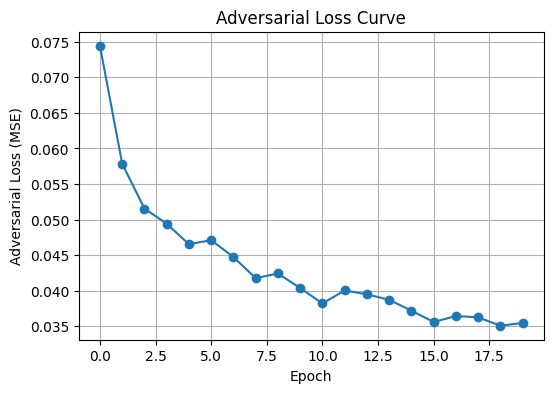

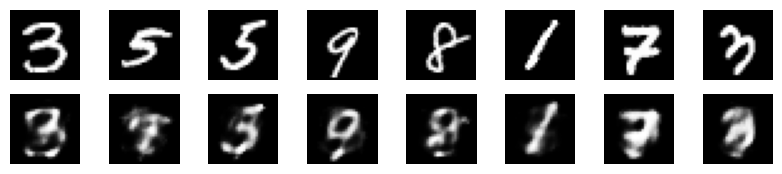

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# ===== Dataset =====
transform = transforms.Compose([transforms.ToTensor()])
train_ds_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Lấy 20% dữ liệu train & test
train_size = int(0.2 * len(train_ds_full))
train_indices = np.random.choice(len(train_ds_full), train_size, replace=False)
train_ds = Subset(train_ds_full, train_indices)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Models =====
latent_dim = 64
num_classes = 10  # vẫn cần label embedding

class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Linear(28*28, latent_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.encoder(x)

encoder = Encoder(latent_dim=latent_dim).to(device)
label_emb = nn.Embedding(num_classes, latent_dim).to(device)
decoder = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 28*28),
    nn.Sigmoid()
).to(device)

optimizer_enc = torch.optim.Adam(list(encoder.parameters()) + list(label_emb.parameters()), lr=1e-3)
optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=1e-3)

# ===== Training =====
num_epochs = 20
adv_loss_curve = []

for epoch in range(num_epochs):
    epoch_adv_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # ===== Update decoder =====
        with torch.no_grad():
            z = encoder(x) + label_emb(y)
        recon = decoder(z)
        loss_dec = F.mse_loss(recon, x.view(-1, 28*28))
        optimizer_dec.zero_grad()
        loss_dec.backward()
        optimizer_dec.step()
        
        # ===== Update encoder to maximize reconstruction error =====
        z = encoder(x) + label_emb(y)
        recon_adv = decoder(z)
        adv_loss = F.mse_loss(recon_adv, x.view(-1, 28*28))
        loss_total = -0.1 * adv_loss  # maximize adv loss
        optimizer_enc.zero_grad()
        loss_total.backward()
        optimizer_enc.step()
        
        epoch_adv_loss += adv_loss.item() * x.size(0)
    
    epoch_adv_loss /= len(train_loader.dataset)
    adv_loss_curve.append(epoch_adv_loss)
    print(f"Epoch {epoch} | Adversarial Loss: {epoch_adv_loss:.4f}")

# ===== Plot adversarial loss curve =====
plt.figure(figsize=(6,4))
plt.plot(range(num_epochs), adv_loss_curve, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Adversarial Loss (MSE)")
plt.title("Adversarial Loss Curve")
plt.grid(True)
plt.show()

# ===== Visual reconstruction =====
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    z = encoder(x) + label_emb(y)
    recon_clean = decoder(z).view(-1, 1, 28, 28)

plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(x[i,0].cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(2,8,i+9)
    plt.imshow(recon_clean[i,0].cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [2]:
encoder_path = "./encoder.pth"
torch.save(encoder.state_dict(), encoder_path)